<a href="https://colab.research.google.com/github/RitoDas1923/ML/blob/main/TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing the Libraries and Dataset**




The required libraries are Scipy,numpy,pandas,statsmodel,sklearn and matplotlib

In [3]:
import scipy
import numpy
import matplotlib
import pandas
import statsmodels
import sklearn
%matplotlib inline

The Dataset is imported form GitHub

In [4]:
from pandas import read_csv
time_series = read_csv("https://raw.githubusercontent.com/RitoDas1923/ML_Datasets/main/monthly_champagne_sales.csv",header=0,  index_col=0, parse_dates=True, squeeze=True)

# **Problem Description**
The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France).

The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data.

The values are a count of millions of sales and there are 105 observations.

# Validation Dataset
The final year of data (September 1971 to September 1972) will be withhold  from analysis and model selection.

This final year of data will be used to validate the final model.

Separating the Validation Dataset

In [5]:
split_point = len(time_series) - 12
training_set, validation_set = time_series[0:split_point], time_series[split_point:]
print('Dataset :  %d, Validation Set :  %d' % (len(training_set), len(validation_set)))
training_set.to_csv('dataset.csv', header=False)
validation_set.to_csv('validation.csv', header=False)

Dataset :  93, Validation Set :  12


# **Baseline Prediction :**
Calculating Baseline Prediction and the Mean-Squared error corresponding to it.This can be done by estimating the sales of (i)th month as the sales of (i+1)th month and calculating the mean-squared error


Preparing the Data

In [6]:
from math import sqrt
from sklearn.metrics import mean_squared_error
X = time_series.values
X = X.astype('float32')
train_size = int(len(X) * 0.70)
train, test = X[0:train_size], X[train_size:]

Prediction and Observation

In [7]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)

    obs = test[i]
    history.append(obs)
    print('>Predicted Value : %.3f, Expected Value : %3.f' % (yhat, obs))

>Predicted Value : 2639.000, Expected Value : 2899
>Predicted Value : 2899.000, Expected Value : 3370
>Predicted Value : 3370.000, Expected Value : 3740
>Predicted Value : 3740.000, Expected Value : 2927
>Predicted Value : 2927.000, Expected Value : 3986
>Predicted Value : 3986.000, Expected Value : 4217
>Predicted Value : 4217.000, Expected Value : 1738
>Predicted Value : 1738.000, Expected Value : 5221
>Predicted Value : 5221.000, Expected Value : 6424
>Predicted Value : 6424.000, Expected Value : 9842
>Predicted Value : 9842.000, Expected Value : 13076
>Predicted Value : 13076.000, Expected Value : 3934
>Predicted Value : 3934.000, Expected Value : 3162
>Predicted Value : 3162.000, Expected Value : 4286
>Predicted Value : 4286.000, Expected Value : 4676
>Predicted Value : 4676.000, Expected Value : 5010
>Predicted Value : 5010.000, Expected Value : 4874
>Predicted Value : 4874.000, Expected Value : 4633
>Predicted Value : 4633.000, Expected Value : 1659
>Predicted Value : 1659.000, 

Root Mean-Square Error 

In [8]:
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE : %.3f' % rmse)

RMSE : 2932.278


# **Data Analysis**
Using summary statistics and plots of the data to quickly learn more about the structure of the prediction problem.

The following Methods will be used :

*   Summary Statistics
*   Line Plot
*   Seasonal Line Plots
*   Density Plots
*   Box & Whisker Plots


## Summary Statistics
Using summary statistics we can get a quic loook at the limits of the values. It helps us better understand the data with which we are working.

In [9]:
training_set.describe()

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: Sales, dtype: float64

## Line Plot
Some observations which can be made from the plot are :

*  There is an increasing trend of sales with time
*  There is seasonality to the sales which appears to be growing over time , indicating a  multiplicative relation.
*  There isn't any outliers.
*  The seasonality indicates non-stationarity of the data

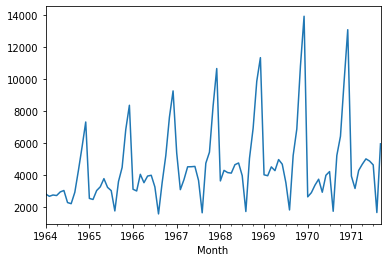

In [10]:
training_set.plot()
matplotlib.pyplot.show()

## Seasonal Line Plots
We can confirm the seasonality of data by plotting line plots by year.
There appears to be a dip in the plot in every August and a jump from August to December each year. 

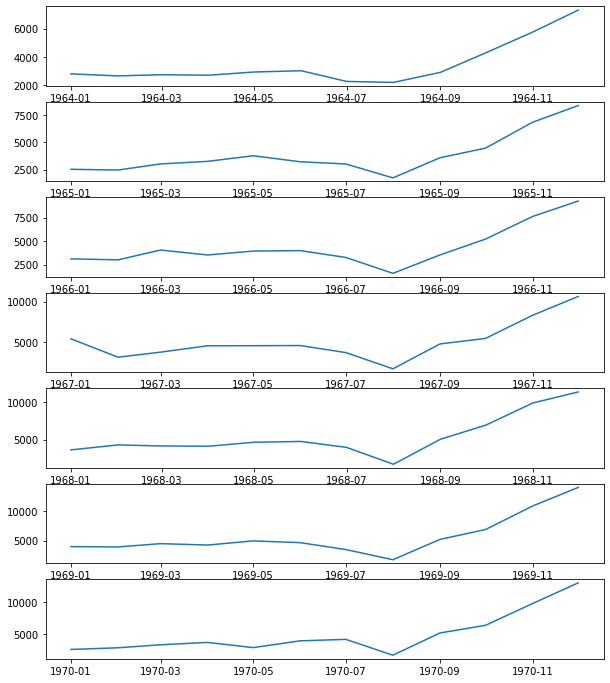

In [11]:
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot as plt
groups = training_set['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
plt.figure(figsize = (10, 12))
i = 1
n_groups = len(groups)
for name, group in groups:
	plt.subplot((n_groups*100) + 10 + i)
	i += 1
	plt.plot(group)
plt.show()

## Density Plot
To get further insight into the data we can plot the density of the observations by using histogram and density plots.

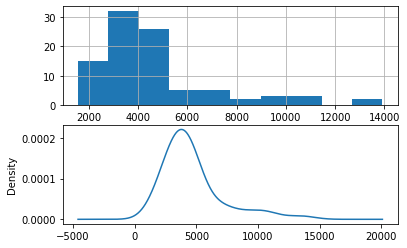

In [12]:
plt.figure(1)
plt.subplot(211)
training_set.hist()
plt.subplot(212)
training_set.plot(kind='kde')
plt.show()

## Box and Whisker Plots
By grouping the monthly data according to year we can get an idea about the spread of observations for every year and how it is changing

Some inferences from reviewing the plots are :

*   The median values for each year (green line) may show an increasing trend.
*   The inter-quartile range  of the data (blue boxes)  appear to be stable.
*   There are outliers each year (black hollow dots); these may be the tops or bottoms of the seasonal cycle.
*   The last year 1970 breaks the trend from previous years .

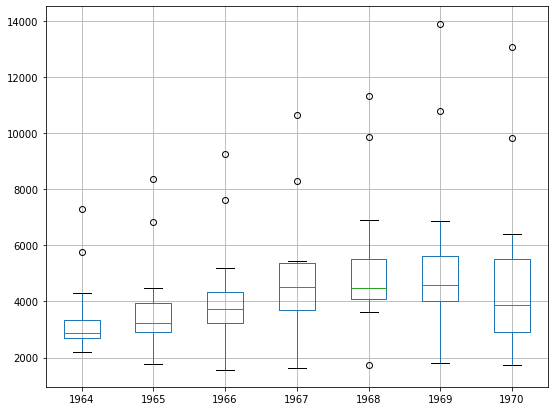

In [13]:
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot(figsize=(9, 7))
plt.show()

# **ARIMA Models**
Developing Autoregressive Integrated Moving Average, or ARIMA, models for the problem.

This can be divided into 3 steps : 

*   Manually Configured ARIMA
*   Automatically configured ARIMA
*   Reviewing Residual Errors



# Manually Configured ARIMA
The **ARIMA(p,d,q)** model requires three parameters and is traditionally configured manually.Analysis of the time series data assumes that we are working with a **stationary time series**.

The time series is almost certainly non-stationary. We can make it stationary this by **first differencing the series and using a statistical test to confirm that the result is stationary**.

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by **subtracting the observation from the same time in the previous cycle**, in this case the same month in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

The code below creates a deseasonalized version of the series and saves it to file **stationary.csv.**

Creating the differenced series

In [14]:
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller



def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
X = training_set.values
X = X.astype('float32')

months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = training_set.index[months_in_year:]


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 Checking for Stationarity using ADF(Augmented Dickey-Fuller Test)

In [15]:
result = adfuller(stationary)
print('ADF Statistic : %f' % result[0])
print('p-value : %f' % result[1])
print('Critical Values : ')
for key, value in result[4].items():
	print('\t%s : %.3f' % (key, value))

ADF Statistic : -7.134898
p-value : 0.000000
Critical Values : 
	1% : -3.515
	5% : -2.898
	10% : -2.586


Since the p value is less than 0.5 and the ADF Statistics is less than the critical value and hence we can reject the null hypothesis and consider the series to be Stationary

Saving and Plotting the stationary series

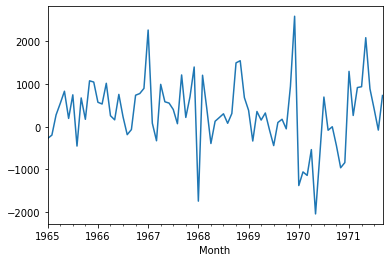

In [16]:
stationary.to_csv('stationary.csv', header=False)
stationary.plot()
plt.show()

Next we need to select the **lag values** and the **Auto Regression(AR) [p] and Moving Average(MA) [q]  parameters** by plotting the **Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.**


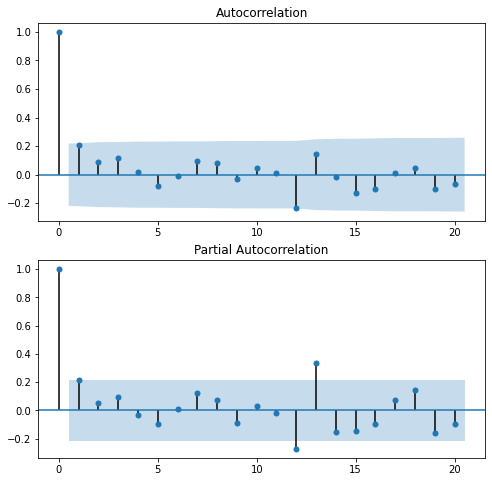

In [17]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
plt.figure(figsize=(8,8))
plt.subplot(211)
plot_acf(stationary, ax=plt.gca())
plt.subplot(212)
plot_pacf(stationary, ax=plt.gca())
plt.show()

The observations from the plots are :

*   The ACF shows a significant lag for 1 month
*   The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12 and 13 months
*   Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

**A good starting point for the p and q values is also 1.**

Though we can take ARIMA(1,0,1) as  the model but experimentation shows that this model of ARIMA does not converge and results in error. By adding one level of differencing to the stationary data we can make the model more stable. Hence model can be extended to **ARIMA(1,1,1)**.


In [26]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt


# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.81)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted : %.3f, Expected : %.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE : %.3f' % rmse)

>Predicted : 4406.357, Expected : 3740.000
>Predicted : 5050.125, Expected : 2927.000
>Predicted : 4449.553, Expected : 3986.000
>Predicted : 3371.198, Expected : 4217.000
>Predicted : 1868.514, Expected : 1738.000
>Predicted : 5172.361, Expected : 5221.000
>Predicted : 6823.426, Expected : 6424.000
>Predicted : 10676.610, Expected : 9842.000
>Predicted : 13672.795, Expected : 13076.000
>Predicted : 2357.242, Expected : 3934.000
>Predicted : 2918.554, Expected : 3162.000
>Predicted : 3297.886, Expected : 4286.000
>Predicted : 3789.384, Expected : 4676.000
>Predicted : 3039.903, Expected : 5010.000
>Predicted : 4446.734, Expected : 4874.000
>Predicted : 4495.677, Expected : 4633.000
>Predicted : 1923.662, Expected : 1659.000
>Predicted : 5289.555, Expected : 5951.000
RMSE : 943.156


By ARIMA model we get an RMSE of 943.156 which is much better than the persistent RMSE 2932.278

# Grid Search ARIMA Hyperparameters
We will search values of p, d, and q for combinations (excluding those that fail to converge), and find the combination that results in the best performance on the test set. We will use a grid search to explore all combinations in a subset of integer values.

We will search all combinations of the following parameters:

*   p : [0, 1, 2, 4, 6, 8]
*   d : 0 to 2
*   q : 0 to 2

In [27]:

import warnings
def evaluate_arima_model(X, arima_order):

	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	predictions = list()
	for t in range(len(test)):
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse


def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE : %.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE : %.3f' % (best_cfg, best_score))


series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

p_values =  [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE : 947.677
ARIMA(0, 0, 1) RMSE : 948.736
ARIMA(0, 0, 2) RMSE : 973.850
ARIMA(0, 1, 0) RMSE : 1157.460
ARIMA(0, 1, 1) RMSE : 979.097
ARIMA(0, 2, 0) RMSE : 1951.373
ARIMA(0, 2, 1) RMSE : 1183.822
ARIMA(1, 0, 0) RMSE : 945.305
ARIMA(1, 1, 0) RMSE : 1080.588
ARIMA(1, 1, 1) RMSE : 966.176
ARIMA(1, 2, 0) RMSE : 1572.459
ARIMA(2, 0, 0) RMSE : 963.295
ARIMA(2, 0, 1) RMSE : 1013.215
ARIMA(2, 1, 0) RMSE : 1040.239
ARIMA(2, 1, 1) RMSE : 981.373
ARIMA(2, 2, 0) RMSE : 1360.312
ARIMA(2, 2, 1) RMSE : 1070.089
ARIMA(4, 0, 0) RMSE : 1004.121
ARIMA(4, 1, 0) RMSE : 1056.074
ARIMA(4, 2, 0) RMSE : 1240.092
ARIMA(4, 2, 1) RMSE : 1118.307
ARIMA(6, 0, 0) RMSE : 1030.144
ARIMA(6, 0, 1) RMSE : 1095.710
ARIMA(6, 1, 0) RMSE : 1028.031
ARIMA(8, 0, 0) RMSE : 1035.772
Best ARIMA(1, 0, 0) RMSE : 945.305


Hence we see the ARIMA(1,0,0) is the Best Model

# Review Residual Errors

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can calculate residual errors by using summary statistics and plot

Loading the datset and splliting into test and train set

In [29]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]


Predicting and Calculating the Errors

                 0
count    19.000000
mean   -209.132752
std     969.490056
min   -2319.579513
25%    -763.911832
50%    -238.533918
75%     523.860810
max    1675.738934


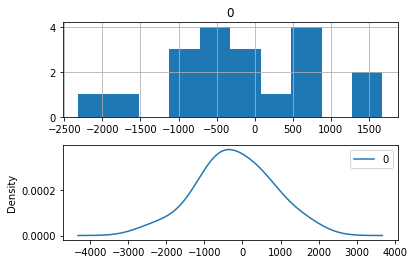

In [30]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,0,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

We can add the value of mean residual error to each observations to make bias-correct predictions

RMSE : 943.632
                  0
count  1.900000e+01
mean  -3.341030e-07
std    9.694901e+02
min   -2.110447e+03
25%   -5.547791e+02
50%   -2.940117e+01
75%    7.329936e+02
max    1.884872e+03


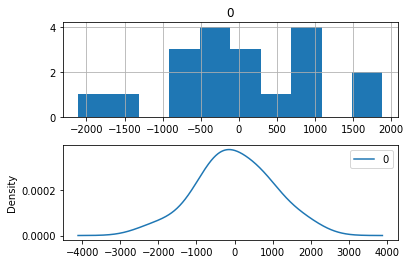

In [31]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -209.132752
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,0,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE : %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

Making bias-correct predictions increases the accuracy slightly

# Finalize Model 
We Fit the ARIMA(1,0,0) model on the entire transformed dataset and save the fit object and bias to a local file which can be used later

In [33]:
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(1,0,0))
model_fit = model.fit()
# bias constant, could be calculated from in-sample mean residual
bias = -209.132752
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

Running the example creates two local files:

*   *model.pkl* : This is the ARIMA Result object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.
*  *model_bias.npy* : This is the bias value stored as a one-row, one-column NumPy array.


# Validate Model 
We test our ARIMA model on the validation set of the last 12 months of the dataset

>Predicted=6619.545, Expected=6981.000
>Predicted=10003.193, Expected=9851.000
>Predicted=13117.255, Expected=12670.000
>Predicted=3877.170, Expected=4348.000
>Predicted=3283.724, Expected=3564.000
>Predicted=4405.997, Expected=4577.000
>Predicted=4772.207, Expected=4788.000
>Predicted=5066.192, Expected=4618.000
>Predicted=4814.648, Expected=5312.000
>Predicted=4753.655, Expected=4298.000
>Predicted=1611.175, Expected=1413.000
>Predicted=5914.632, Expected=5877.000
RMSE: 339.131


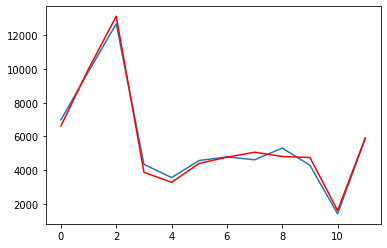

In [34]:
from statsmodels.tsa.arima_model import ARIMAResults
X = training_set.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,0,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

Thus the Final RMSE is 339.131 which is pretty accurate.
This model can be hence used to predict sales for any future year.